# Portfolio Optimization with Monte Carlo Simulation and Modern Portfolio Theory

## Abstract
This project will follow the classic [Modern Portfolio Theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory) of Harry Markowitz. The project aims to utilize Monte Carlo simulation and Modern Portfolio Theory (MPT) to determine the optimal weights of stocks in a portfolio. The goal is to construct an efficient frontier using historical stock data and MPT, allowing for maximized returns while minimizing risks. A Monte Carlo simulation will be performed to test various stock weights in the portfolio of specific stocks in order to find the optimal allocation.

## Introduction

### 1. What is Modern Portfolio Theory

Modern Portfolio Theory (MPT) is a theory of investment that aims to maximize expected return while minimizing risk by carefully choosing the proportion of various assets in a portfolio. At its core, MPT provides a quantitative approach to the concept of diversification that aims to help investors achieve their financial goals by constructing portfolios that balance risk and reward.

#### Advantages and Disadvantages of MPT

**Advantages of Modern Portfolio Theory:**

By diversifying investments across multiple asset classes, MPT aims to optimize the risk-return tradeoff of a portfolio, potentially leading to better risk-adjusted returns.
MPT encourages investors to assess their risk tolerance, goals, and investment horizon, which can lead to a more structured investment plan.
The theory provides a framework for understanding portfolio construction and risk management.

**Disadvantages of Modern Portfolio Theory:**

MPT relies on statistical data, which can be unreliable and calculated with assumptions that do not match reality.
The theory assumes that the returns of assets are normally distributed, which can lead to errors when applied to non-normal asset classes.
MPT places a greater emphasis on maximizing returns rather than minimizing losses or considering downside risk, which may not be suitable for all investors.

#### MPT formula

- Expected return:
$$
\mathrm{E}\left(R_p\right)=\sum_i w_i \mathrm{E}\left(R_i\right)
$$
where $R_p$ is the return on the portfolio, $R_i$ is the return on asset $i$ and $w_i$ is the weighting of component asset $i$ (that is, the proportion of asset "i" in the portfolio, so that $\sum_i w_i=1$ ).
- Portfolio return variance:
$$
\sigma_p^2=\sum_i w_i^2 \sigma_i^2+\sum_i \sum_{j \neq i} w_i w_j \sigma_i \sigma_j \rho_{i j}
$$
where $\sigma_i$ is the (sample) standard deviation of the periodic returns on an asset $i$, and $\rho_{i j}$ is the correlation coefficient between the returns on assets $i$ and $j$. Alternatively the expression can be written as:
$$
\sigma_p^2=\sum_i \sum_j w_i w_j \sigma_i \sigma_j \rho_{i j}
$$
where $\rho_{i j}=1$ for $i=j$, or
$$
\sigma_p^2=\sum_i \sum_j w_i w_j \sigma_{i j}
$$
where $\sigma_{i j}=\sigma_i \sigma_j \rho_{i j}$ is the (sample) covariance of the periodic returns on the two assets, or alternatively denoted as $\sigma(i, j)$, $\operatorname{cov}{ }_{i j}$ or $\operatorname{cov}(i, j)$.
- Portfolio return volatility (standard deviation):
$$
\sigma_p=\sqrt{\sigma_p^2}
$$

### 3. Optimize MPT with Monte Carlo

Monte Carlo simulation is a mathematical technique used to predict the probability of a range of outcomes when dealing with potential random variables. It involves using computer programs to run random experiments and analyze the results to gain insights into the likelihood of certain outcomes.

By simulating a large number of potential market scenarios and running them through the portfolio optimization process such as MPT, the two methods can be combined to identify the most robust and efficient portfolio weights that yield the maximum returns at the lowest risk level.

## Implementation

### Extract Data
Extract data from Financial Modelling Prep API

In [ ]:
%pip install -r requirements.txt

In [65]:
import os
from dotenv import load_dotenv
import ssl
from urllib.request import urlopen
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

load_dotenv()
API_KEY = os.getenv('API_KEY')
base_url = "https://financialmodelingprep.com/api/v3"

In [68]:
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    context = ssl.create_default_context()
    response = urlopen(url, context=context)
    data = response.read().decode("utf-8")
    return json.loads(data)

In [69]:
def get_historical_price_full(stickers, file_path):
    """
    Extract historical 1yr daily price for stock stickers, and save to json file with file_path

    Parameters:
      stickers (list): list of stock stickers
      file_path (str): json data file

    Returns:
      Json object of historical stock prices of all stocks in the list
    """
    stickers_str = ','.join(stickers)

    url = (f"{base_url}/historical-price-full/{stickers_str}?apikey={API_KEY}")

    data = get_jsonparsed_data(url)

    with open(file_path, "w") as f:
        if len(stickers) == 1:
          json.dump(data, f)   
        else:
          json.dump(data["historicalStockList"], f)

    return data

def get_historical_price(stock, start_date, end_date):
    """
    Extract historical daily price for 1 stock, and save to json file with file_path

    Parameters:
      stocks (list): list of stocks
      file_path (str): json data file

    Returns:
      Json object of historical stock prices of all stocks in the list
    """

    url = (f"{base_url}/historical-price-full/{stock}?from={start_date}&to={end_date}&apikey={API_KEY}")

    data = get_jsonparsed_data(url)

    
    directory = f"data/{stock}/"
    file_name = f"{start_date}_{end_date}.json"
    file_path = directory + file_name

    # Create the directory if it does not already exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")
    else:
        print(f"Directory '{directory}' already exists.")

    with open(file_path, "w") as f:
      json.dump(data, f)

    return data

def get_quote(stocks, file_path):
    """
    Extract current price for stock, and save to json file with file_path

    Parameters:
      stocks (list): list of stock stocks
      file_path (str): json data file

    Returns:
      Json object of historical stock prices of all stocks in the list
    """
    stocks_str = ','.join(stocks)

    url = (f"{base_url}/quote/{stocks_str}?apikey={API_KEY}")

    data = get_jsonparsed_data(url)

    with open(file_path, "w") as f:
        json.dump(data, f)   
    return data

### Process Data

In [70]:
def get_json_data(file_path):
  # open the JSON file
  with open(file_path, 'r') as f:
      # load the JSON object into a Python object
      json_obj = json.load(f)

  columns = list(json_obj['historical'][0].keys())
  df = pd.DataFrame(columns=['symbol'] + columns)
  symbol = json_obj['symbol']
  historical = json_obj['historical']
  data = pd.DataFrame(historical, columns=columns)
  data.insert(0, 'symbol', symbol)
  df = pd.concat([df, data])
  return df

def get_data(file_path):
  """
  Return a cleaned pandas dataframe of historical full stock price information from json file
  """
  df = pd.read_json(file_path)
  # use explode to split a list to multiple rows
  explode_df = df.explode('historical')
  # use apply and pd.Series to split dictionary column into multiple columns
  normalize_df = explode_df['historical'].apply(pd.Series)
  # concatenate 'symbol' column to the normalized_df by column (axis=1)
  df_final = pd.concat([explode_df['symbol'], normalize_df], axis=1)
  return df_final


### Modern Portfolio Theory

In [71]:
def cal_return(df):
  """
  Return a pandas dataframe of adjusted close price for each stock sticker
  """
  pivot_df = df.pivot(index = 'date', columns='symbol', values = 'adjClose')
  returns = pivot_df.pct_change()
  mean_returns = returns.mean()
  cov_matrix = returns.cov()
  return pivot_df, mean_returns, cov_matrix
  
def cal_portfolio_performance(weights, mean_returns, cov_matrix):
  """
  Given porfolio weight, calculate portfolio return and standard deviatzion based on modern portfolio theory
  
  Parameters: 
    mean_returns
    cov_matrix
    weights (numpy array): array of weights for each stock sticker

  Returns:
    portfolio_return (float):  Sum(mean_returns * weights) * trading_days
    porfolio_std (float):  weights_transposed * cov_matrix * weights
  """
  trading_days = 252
  portfolio_returns = round(np.sum(mean_returns * weights) * trading_days, 4)
  portfolio_std = round(np.sqrt( np.dot(weights.T, np.dot(cov_matrix, weights)) ), 4)
  return portfolio_returns, portfolio_std

### Monte Carlo Simulation

In [72]:
def cal_portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate = 0.0, index=0):
    
    '''
    This function generates the relative performance metrics that will be reported and will be used
    to find the optimal weights.
    
    Parameters
    ---
    weights (numpy array): initialized weights or optimal weights for performance reporting
    cov_matrix (pd dataframe): covariance matrix of stock ,
    risk_free_rate (float): risk free rate such as t-bill, default is 0.0

    Returns
    ---
    pandas dataframe of a portfolio performance
    '''   
    portfolio_returns, portfolio_std = cal_portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (portfolio_returns - risk_free_rate)/portfolio_std
    df = pd.DataFrame({"Expected Return": portfolio_returns,
                       "Portfolio Variance":portfolio_std**2,
                       'Portfolio Std': portfolio_std,
                       'Sharpe Ratio': sharpe}, index=[index])
    return df

## Main

Extract 10 years of historical stock price data

In [73]:
stocks = ["AAPL", "MSFT", "TSLA", "AMD", "AMZN", "GOOG"]
end_date = datetime.now().date()
start_date = end_date - timedelta(days=3650)
risk_free_rate = 0.05

for stock in stocks:
    get_historical_price(stock, start_date, end_date)

Directory 'data/AAPL/' already exists.
Directory 'data/MSFT/' already exists.
Directory 'data/TSLA/' already exists.
Directory 'data/AMD/' already exists.
Directory 'data/AMZN/' already exists.
Directory 'data/GOOG/' created.


In [74]:

df = pd.DataFrame()
for stock in stocks:
    file_path = f"data/{stock}/{start_date}_{end_date}.json"
    pdf = get_json_data(file_path)
    df = pd.concat([df, pdf], axis = 0)

In [95]:
pivot_df, mean_returns, cov_matrix = cal_return(df)
display(pivot_df)

symbol,AAPL,AMD,AMZN,GOOG,MSFT,TSLA
date,,,,,,
2013-06-05,13.801541,3.910000,13.358500,21.412243,28.982716,6.358000
2013-06-06,13.595348,3.940000,13.391500,21.535280,29.132713,6.490000
2013-06-07,13.699220,3.910000,13.843500,21.911121,29.724371,6.802667
2013-06-10,13.608677,4.060000,14.053500,22.172392,29.557713,6.670000
2013-06-11,13.568680,3.960000,13.739000,21.913115,29.032707,6.298000
...,...,...,...,...,...,...
2023-05-26,175.429993,127.029999,120.110001,125.430000,332.890015,193.169998
2023-05-30,177.300003,125.269997,121.660004,124.639999,331.209991,201.160004
2023-05-31,177.250000,118.209999,120.580002,123.370003,328.390015,203.929993


In [89]:
def simulate_portfolios( mean_returns, cov_matrix, risk_free_rate=0.0, n=100):
    """
    Given the historical mean_returns and cov_matrix of the portfolio, as well as the risk_free_rate
    Simulate n portfolios with different weights and performance

    Parameters
    ---
    mean_returns (float): historical mean_returns
    cov_matrix (pd dataframe): covariance matrix of stock ,
    risk_free_rate (float): risk free rate such as t-bill, default is 0.0
    n: number of simulations, default is 100

    Returns
    ---
    portfolios (pandas dataframe): pandas dataframe of n portfolios and their expected performances
    """
    np.random.seed(42)
    #Empty Container
    portfolios = pd.DataFrame(columns=[*stocks, "Expected Return","Portfolio Variance", "Portfolio Std", "Sharpe Ratio"])
    #Loop
    for i in range(n):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        portfolios.loc[i, stocks] = weights
        metrics = cal_portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate = risk_free_rate, index=i)
        # print(metrics)
        portfolios.loc[i, ["Expected Return","Portfolio Variance", "Portfolio Std", "Sharpe Ratio"]] \
            = metrics.loc[i,["Expected Return","Portfolio Variance", "Portfolio Std", "Sharpe Ratio"]]
        
    return portfolios


In [79]:
portfolios = simulate_portfolios(mean_returns, cov_matrix, risk_free_rate=risk_free_rate, n=10000)

### Efficient Frontier of Expected Return and Portfolio Standard deviation

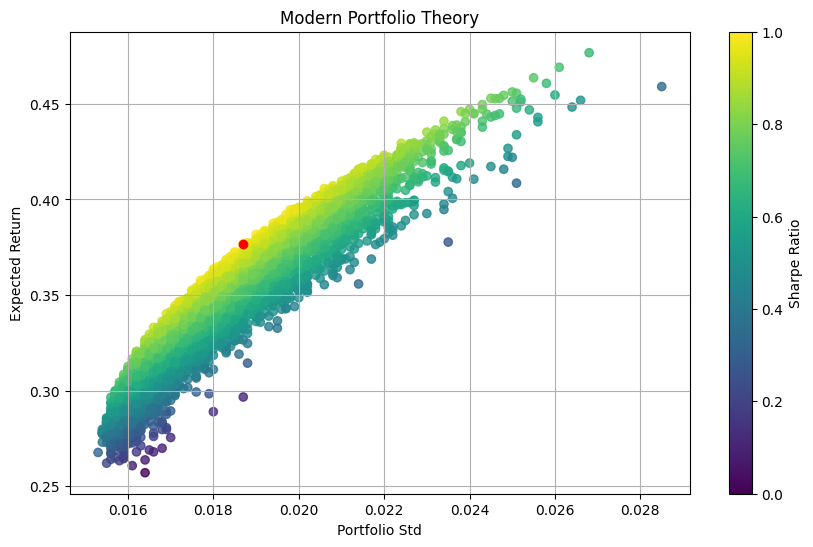

In [80]:
# Extract the expected returns and portfolio standard deviations
expected_returns = portfolios["Expected Return"].astype(float)
portfolio_std = portfolios["Portfolio Std"].astype(float)
sharpe_ratio = portfolios["Sharpe Ratio"].astype(float)

# Find the point with the lowest portfolio standard deviation
min_std_index = portfolio_std.idxmin()
min_std_std, min_std_return = portfolio_std[min_std_index], expected_returns[min_std_index] 

# Find the point with the highest expected return
max_return_index = expected_returns.idxmax()
max_return_std, max_return_return = portfolio_std[max_return_index], expected_returns[max_return_index] 

# Find the point with the lowest expected return
min_return_index = expected_returns.idxmin()
min_return_std, min_return_return = portfolio_std[min_return_index], expected_returns[min_return_index] 

# Find the point with the max Sharpe Ratio
max_sharpe_index = sharpe_ratio.idxmax()
max_sharpe_std, max_sharpe_return = portfolio_std[max_sharpe_index], expected_returns[max_sharpe_index] 

plt.figure(figsize=(10, 6))
plt.scatter(portfolios["Portfolio Std"], portfolios["Expected Return"], c=portfolios["Sharpe Ratio"], cmap="viridis", alpha=0.8)
plt.scatter(max_sharpe_std, max_sharpe_return, color='red', marker='o',label='Max Sharpe Ratio' )
plt.xlabel("Portfolio Std")
plt.ylabel("Expected Return")
plt.title("Modern Portfolio Theory")
plt.colorbar(label="Sharpe Ratio")
plt.grid(True)
plt.show()

### Identify the portfolio with highest Sharpe Ratio

In [81]:
portfolios[portfolios["Sharpe Ratio"]==portfolios["Sharpe Ratio"].max()]

,AAPL,MSFT,TSLA,AMD,AMZN,GOOG,Expected Return,Portfolio Variance,Portfolio Std,Sharpe Ratio
3710,0.296501,0.205096,0.056299,0.005315,0.244698,0.192091,0.3769,0.00035,0.0187,17.481283


The optimal portfolio weights with highest Sharpe Ratio has 29% Apple, 24% Amazon, 20% Microsoft and 19% Google

### Identify the portfolio with lowest Volatility

In [82]:
portfolios[portfolios["Portfolio Std"]==portfolios["Portfolio Std"].min()]

,AAPL,MSFT,TSLA,AMD,AMZN,GOOG,Expected Return,Portfolio Variance,Portfolio Std,Sharpe Ratio
552,0.339808,0.00401,0.104358,0.317235,0.232042,0.002547,0.2677,0.000234,0.0153,14.228758


# Reference
1. https://ocw.mit.edu/courses/6-0002-introduction-to-computational-thinking-and-data-science-fall-2016/
2. https://www.investopedia.com/terms/m/modernportfoliotheory.asp
3. https://quantpy.com.au/category/monte-carlo/

